<a href="https://colab.research.google.com/github/ps1303/Project/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Neural Networks Learning

## Introduction

In this assignment, you will implement the feedforward and backpropagation algorithm for neural networks and apply it to the task of `Fashion MNIST` recognition.

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the notebook, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

## Import libraries.

In [ ]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
import pandas as pd
# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [ ]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    m,n=figsize
    pyplot.figure(figsize=(10,10))

    fig, axes=pyplot.subplots(m,n,figsize=(10,10))

    for i in range(m*n):
        ax=axes.flat[i]
        indi=np.random.randint(X.shape[0])
        X_new=X[indi].reshape((28,28)).T
        ax.imshow(X_new)


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def tanh(z):
    return (2/(1+np.exp(-2*z)))-1

## Neural Networks

In this exercise, you will implement the feedforward propagation for neural networks to predict fashion products. Later, the backpropagation algorithm will be implemented to learn the parameters for the neural network.

We start the exercise by first loading the dataset.

In [ ]:
#  training data stored in arrays X, y
data = pd.read_csv('fashion-mnist_train.csv')
#Load X and y.
def set(data):
        y = data.label.values
        X = data.drop('label', axis=1)
        X = np.array(X)
        R=X
        X = (X - X.min(axis=1)[:,None])/((X.max(axis=1) - X.min(axis=1))[:,None])
        y = np.array(y)
        return R,X,y

R,X,y = set(data)


### 1.1 Visualizing the data

There are 10000 training examples in `fashion-mnist_train`, where each training example is a 28 pixel by 28 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 28 by 28 grid of pixels is “unrolled” into a 784-dimensional vector. Each
of these training examples becomes a single row in our data matrix $X$. This gives us a 10000 by 784 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

The second part of the training set is a 10000-dimensional vector `y` that contains labels for the training set.
The following cell randomly selects 100 images from the dataset and plots them.

<Figure size 1200x1500 with 0 Axes>

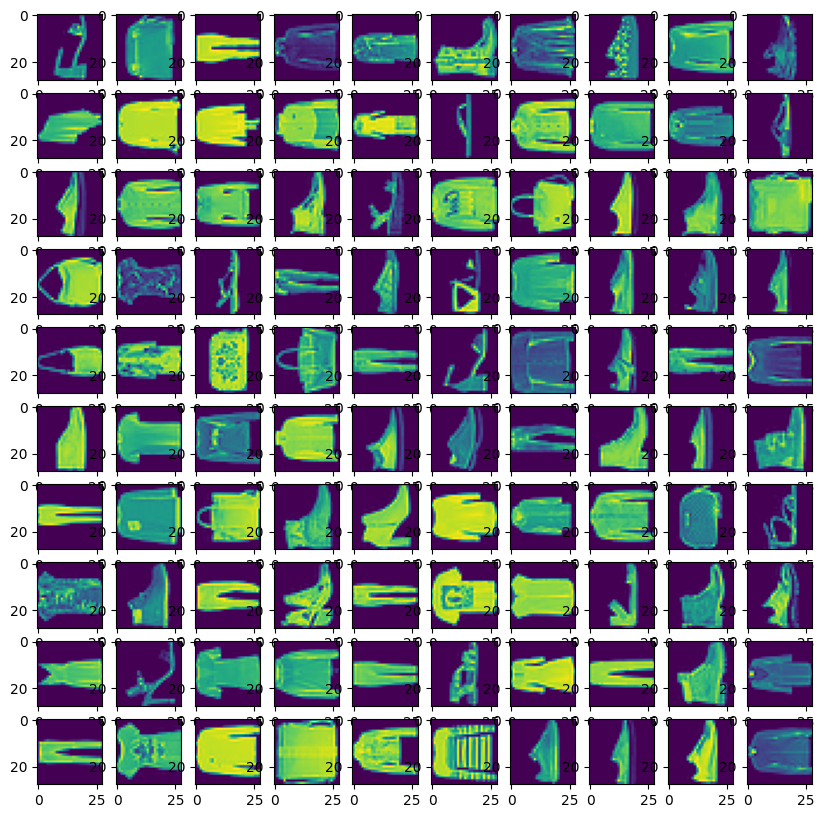

In [ ]:
# Randomly select 100 data points to display
pyplot.figure(figsize = (12,15))
fig, axes=pyplot.subplots(10,10, figsize=(10,10))

for i in range(100):
    ax=axes.flat[i]
    indi=np.random.randint(R.shape[0])
    X_new=R[indi].reshape((28,28)).T
    ax.imshow(X_new)

### 1.2 Model representation



The schematic of neural network is shown in the following figure.

![](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values
of digit images. Since the images are of size $28 \times 28$, this gives us 784 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables `X` and `y` above.


In [ ]:
# Setup the parameters you will use for this exercise
input_layer_size  =784  # 28x28 Input Images of Digits
hidden_layer1_size = 50 # 50 hidden units
hidden_layer2_size = 50 # 50 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# w1 has size = 785*50 =  39250
# w2 has size = 51*50 = 2550
# w3 has size = 51*10 = 510

## Feedforward Method

### Unregularized Cost Function

Now you will implement the cost function and gradient for the neural network.

Recall that the cost function for the neural network (without regularization) is:

$$ J(w) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_w \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_w \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_w \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_w(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y =
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_w(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(w) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_w \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_w \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{l=1}^{L-1} \sum_{i=1}^{S_{l}} \sum_{j=1}^{S_{l+1}} \left( w_{ji}^{(l)} \right)^2 \right] $$

Note that the terms corresponding to the bias should not be regularized. For the matrices `w1`, `w2` and `w3`, this corresponds to the first column of each matrix. You should now add regularization to your cost function.

## Backpropagation- A brief introduction.

Backpropagation is the heart of every neural network. Firstly, we need to make a distinction between backpropagation and optimizers.

Backpropagation is for calculating the gradients efficiently, while optimizers is for training the neural network, using the gradients computed with backpropagation. In short, all backpropagation does for us is compute the gradients. Nothing more.

### How does it work

We always start from the output layer and propagate backwards, updating weights and biases for each layer.

The idea is simple: adjust the weights and biases throughout the network, so that we get the desired output in the output layer. Say we wanted the output neuron to be 1.0, then we would need to nudge the weights and biases so that we get an output closer to 1.0.

We can only change the weights and biases, but activations are direct calculations of those weights and biases, which means we indirectly can adjust every part of the neural network, to get the desired output — except for the input layer, since that is the dataset that you input.

### Computing Gradients

Firstly, let's start by defining the relevant equations. Note that any indexing explained earlier is left out here, and we abstract to each layer instead of each weight, bias or activation:

\begin{equation}
z^{(L)}=w^{(L)} \times x +b \newline
a^{(L)}=
    g\left(
    \boldsymbol{z}^{(L)}
    \right) \newline
    C=(a^{(L)}-y)^2
\end{equation}


The **gradient** of this Cost Function C in the backpropagation algorithm, can be then be thought of as the change  in the cost function in relation to a specific weight. Therefore the change of Cost Function with respect to weights w can be best captured by:

Then you would update the weights after each mini-batch. Each weight is 'nudged' a certain amount for each layer l
\begin{equation}
w^{(l)} = w^{(l)} - \text{learning rate} \times \frac{\partial C}{\partial w^{(l)}}
\end{equation}

We have to move all the way back through the network and adjust each weight, iteratively.

## Backpropagation Method

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. You will need to update the function `nnCostFunction` so that it returns an appropriate value for `grad`. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(w)$ using an advanced optimizer such as `scipy`'s `optimize.minimize`.
You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.

![](Figures/ex4-backpropagation.png)

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_w(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set
$$ \delta^{(2)} = \left( w^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<a id="section3"></a>
### Sigmoid Gradient

To help you get started with this part of the exercise, you will first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.
<a id="sigmoidGradient"></a>

In [ ]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z.

    Parameters
    ----------
    z : array_like : A vector or matrix as input to the sigmoid function.

    Returns
    --------
    g : array_like : Gradient of the sigmoid function. Has the same shape as z.

    """
    r=sigmoid(z)
    x=1-sigmoid(z)
    g=r*x
    return g


### Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $w^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. We are going to use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

Use the function `randInitializeWeights` to initialize the weights for $w$. Note that the function has been provided with an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [ ]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.

    Parameters
    ----------
    L_in : int : Number of incomming connections.

    L_out : int : Number of outgoing connections.

    epsilon_init : float, optional : Range of values which the weight can take from a uniform distribution.

    """
    a=-1*(epsilon_init)
    W=np.random.uniform(a, epsilon_init, (L_out,L_in+1))
    return W


In [ ]:
#randomly initialise weights for two different layers
initial_w1 = randInitializeWeights(input_layer_size,hidden_layer1_size)
initial_w2 = randInitializeWeights(hidden_layer1_size,hidden_layer2_size)
initial_w3 = randInitializeWeights(hidden_layer2_size,num_labels)
# Unroll parameters into a single array
initial_nn_params = np.concatenate([initial_w1.ravel(), initial_w2.ravel(), initial_w3.ravel()], axis=0)


<a id="section5"></a>
### Regularized Neural Network

After you have successfully implemented the backpropagation algorithm, you also need to add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align}
& \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial w_{ij}^{(l)}} J(w) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} w_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $w^{(l)}$ which is used for the bias term. Furthermore, in the parameters $w_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus,

$$
w^{(l)} = \begin{bmatrix}
w_{1,0}^{(i)} & w_{1,1}^{(l)} & \cdots \\
w_{2,0}^{(i)} & w_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

In [ ]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer1_size,
                   hidden_layer2_size,
                   num_labels,
                   X, y, lambda_=0.1):
    """
    Implements the neural network cost function and gradient for a two layer neural
    network which performs classification.

    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into
        a vector.

    input_layer_size : int
        Number of features for the input layer.

    hidden_layer1_size : int
        Number of hidden units in the second layer.

    hidden_layer2_size : int
        Number of hidden units in the third layer.

    num_labels : int
        Total number of labels, or equivalently number of units in output layer.

    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).

    y : array_like
        Dataset labels. A vector of shape (m,).

    lambda_ : float, optional
        Regularization parameter.

    Returns
    -------
    J : float : The computed value for the cost function at the current weight values.

    grad : array_like : An "unrolled" vector of the partial derivatives of the concatenatation of
                        neural network weights w1 and w2.
    """

    # Reshape nn_params back into the parameters w1 and w2, the weight matrices
    # for our 2 layer neural network

    w1 = np.reshape(nn_params[:hidden_layer1_size * (input_layer_size+1)],
                        (hidden_layer1_size, (input_layer_size +1)))
    w2 = np.reshape(nn_params[hidden_layer1_size * (input_layer_size +1):hidden_layer1_size * (input_layer_size +1) +
                              hidden_layer2_size * (hidden_layer1_size +1)], (hidden_layer2_size, (hidden_layer1_size +1)))
    w3 = np.reshape(nn_params[hidden_layer1_size * (input_layer_size +1)+ hidden_layer2_size* (hidden_layer1_size +1):],
                        (num_labels, (hidden_layer2_size +1)))

    # Setup some useful variables
    m = y.size
    new_col=np.ones((m,1))
    new_array = np.concatenate((new_col, X), axis=1)
    # You need to return the following variables correctly
    J = 0
    w1_grad = np.zeros(w1.shape)
    w2_grad = np.zeros(w2.shape)
    w3_grad = np.zeros(w3.shape)

    # ================================================================================================
    w11_1=np.dot(new_array,w1.T)
    new_col_1=np.ones((m,1))
    w11 = np.concatenate((new_col_1, w11_1), axis=1)
    w11=sigmoid(w11)
    w22_1=np.dot(w11,w2.T)
    new_col_2=np.ones((m,1))
    w22 =np.concatenate((new_col_2, w22_1), axis=1)
    w22=sigmoid(w22)
    w33=np.dot(w22,w3.T)
    w33=sigmoid(w33)

    n=w33.shape[1]

    result_array = np.zeros((m, n))
    for i, index in enumerate(y):
        result_array[i, index] = 1

    a1=w1
    a2=w2
    a3=w3
    r=(lambda_/(2*m))*(np.sum(np.square(a1[:,1:]))+np.sum(np.square(a2[:,1:]))+np.sum(np.square(a3[:,1:])))
    J=(-1/m)*np.sum(np.log(w33)*result_array+np.log(1-w33)*(1-result_array))+r
    # Add regularization term
    # Backpropogation

    d4=w33-result_array
    g3=np.dot(d4.T,w22)
    d3_1=np.dot(d4,w3)
    d3_2=sigmoidGradient(np.dot(w11,w2.T))
    d3=d3_1[:,1:]*d3_2
    g2=np.dot(d3.T,w11)
    d2_1=np.dot(d3,w2)
    d2_2=sigmoidGradient(np.dot(new_array,w1.T))
    d2=d2_1[:,1:]*d2_2
    g1=np.dot(d2.T,new_array)

    w1_grad=(1/m)*g1
    w2_grad=(1/m)*g2
    w3_grad=(1/m)*g3

    w1_grad[:,1:]=w1_grad[:,1:]+(lambda_/m)*w1[:,1:]
    w2_grad[:,1:]=w2_grad[:,1:]+(lambda_/m)*w2[:,1:]
    w3_grad[:,1:]=w3_grad[:,1:]+(lambda_/m)*w3[:,1:]
    grad=np.concatenate([w1_grad.ravel(), w2_grad.ravel(),w3_grad.ravel()], axis=0)
    #=======================================================================================================

    return J, grad


In [ ]:
#Initialize parameters
w1 = randInitializeWeights(input_layer_size,hidden_layer1_size)
w2 = randInitializeWeights(hidden_layer1_size,hidden_layer2_size)
w3 = randInitializeWeights(hidden_layer2_size,num_labels)
initial_nn_params = np.concatenate([w1.ravel(), w2.ravel(), w3.ravel()], axis=0)


### Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [ ]:
#  After you have completed the assignment, change the maxiter to a larger value to see how more training helps.
options= {'maxiter': 400}

#  You should also try different values of lambda
lambda_ = 0.1

# Create "short hand" for the cost function to be minimized

costFunction = lambda p: nnCostFunction(p, input_layer_size, # p == nn_param
                                        hidden_layer1_size,hidden_layer2_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

C:\Users\91993\AppData\Local\Temp\ipykernel_9232\786460301.py:15: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = optimize.minimize(costFunction,


In [ ]:
res

 message: Max. number of function evaluations reached
 success: False
  status: 3
     fun: 0.25394788473642393
       x: [ 3.437e-01  9.933e-02 ... -3.188e+00 -3.086e-01]
     nit: 35
     jac: [ 2.046e-05  9.933e-07 ... -1.072e-04 -5.339e-04]
    nfev: 400

In [ ]:
# get the solution of the optimization
nn_params = res.x #Row vector containing weight values for every layer of your implemented neural network

# Obtain w1, w2 and w3 back from nn_params
w1 = np.reshape(nn_params[:hidden_layer1_size * (input_layer_size+1)],
                        (hidden_layer1_size, (input_layer_size +1)))
w2 = np.reshape(nn_params[hidden_layer1_size * (input_layer_size +1):hidden_layer1_size * (input_layer_size +1) +
                              hidden_layer2_size * (hidden_layer1_size +1)], (hidden_layer2_size, (hidden_layer1_size +1)))
w3 = np.reshape(nn_params[hidden_layer1_size * (input_layer_size +1)+ hidden_layer2_size* (hidden_layer1_size +1):],
                        (num_labels, (hidden_layer2_size +1)))

After the training completes, we will proceed to report the training accuracy of classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported
training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try
training the neural network for more iterations (e.g., set `maxiter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [ ]:
#forward propagation

def predict(w1, w2, w3, X):
    if X.ndim == 1:
        X = X[None]

    m = X.shape[0]
    new_col=np.ones((m,1))
    new_array = np.concatenate((new_col, X), axis=1)
    w11_1=np.dot(new_array,w1.T)
    new_col_1=np.ones((m,1))
    w11 = np.concatenate((new_col_1, w11_1), axis=1)
    w11=sigmoid(w11)
    w22_1=np.dot(w11,w2.T)
    new_col_2=np.ones((m,1))
    w22 =np.concatenate((new_col_2, w22_1), axis=1)
    w22=sigmoid(w22)
    w33=np.dot(w22,w3.T)
    w33=sigmoid(w33)

    p = w33

    predictions = np.argmax(p, axis=1)

    return predictions


In [ ]:
pred = predict(w1, w2, w3, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 97.020000


In [ ]:
# if indices.size > 0:
#     i, indices = X[0], X[1:]
#     displayData(X[i, :], figsize=(4, 4))
#     pred = predict(w1, w2, X[i, :])
#     print('Neural Network Prediction: {}'.format(*pred))
# else:
#     print('No more images to display!')